In [1]:
import pandas as pd

### origin data

In [2]:
data = pd.read_csv("data.csv")

In [3]:
data.head()

,题型ID,试题ID,材料,题干,选项,答案,解析
0,127,562593,Where I'm from， we're pretty [u] 1 [/u](re...,[blank=4],NaN,[|||]to be[|||],句意：所以我要努力做到准时。make an effort to do sth努力做某事，所...
1,127,562596,Where I'm from， we're pretty [u] 1 [/u](re...,[blank=4],NaN,[|||]to meet[|||],句意：如果有人邀请你在中午见他，你被期待中午到那里。invite sb to do sth邀...
2,127,562597,Where I'm from， we're pretty [u] 1 [/u](re...,[blank=4],NaN,[|||]to be[|||],句意：在瑞士，准时是重要的。此处填写动词不定式to be，在句中做真实主语。
3,127,562598,Where I'm from， we're pretty [u] 1 [/u](re...,[blank=4],NaN,[|||]seeing[|||],句意：我们经常围绕中心散步，尽可能多地看见我们的朋友。此处填写现在分词seeing，作伴随状语。
4,127,562599,Where I'm from， we're pretty [u] 1 [/u](re...,[blank=4],NaN,[|||]to shake[|||],句意：当我们彼此见面时，握手是有礼貌的。此处填写动词不定式to shake，在句中做真实主语。


In [4]:
data.groupby("题型ID").size()

题型ID
38     1914
39      856
40     3723
42     1078
43      236
44     1992
45     2093
46     2379
47     5729
48       60
49     4449
127    1604
142     457
146    1957
148    1144
264     570
399     853
400     154
432     485
433    2651
434     141
435    1463
dtype: int64

### get feature data and split data to train and test

In [5]:
import numpy as np
import re
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.extmath import density
from time import time
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [6]:
with open("fill_problem_feature2","r") as f:
    features = f.readlines() 

In [7]:
len(features)

35986

In [8]:
features[:2]

['127\t562593\t0 0 0 0 21 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 23 4 364 5 0 10 0 0 0 0 0 0 10 10 \n',
 '127\t562596\t0 0 0 0 34 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 21 6 364 5 0 10 0 0 0 0 0 0 10 10 \n']

In [8]:
features[100]

'127\t895697\t0 0 0 0 32 17 0 0 0 7 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 47 4 456 5 0 13 0 0 1 0 0 0 14 14 \n'

In [9]:
def get_data(data_dir):
    with open(data_dir,'r',encoding='utf-8') as f:
        data_list = f.readlines()
    X,Y,ID = [],[],[]
    for line in data_list:
        y = int(line.split('\t')[0])
        i = int(line.split('\t')[1])
        x = [float(n) for n in line.split('\t')[2].split()]
        X.append(x)
        Y.append(y)
        ID.append(i)
    X = np.array(X)
    Y = np.array(Y)
    x_train,x_test,y_train,y_test,id_train,id_test = train_test_split(X,Y,ID,test_size=0.3,random_state=0)
    return x_train,x_test,y_train,y_test,id_train,id_test

In [10]:
x_train,x_test,y_train,y_test ,id_train,id_test =  get_data("fill_problem_feature2") 

In [11]:
print("train data : {}".format(len(x_train)))
print("test_data : {}".format(len(x_test)))

train data : 25190
test_data : 10796


### experiment with models

In [12]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(x_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(x_test)
    pred_train = clf.predict(x_train)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_train,pred_train )
    print("train accuracy:   %0.3f" % score)

    score = metrics.accuracy_score(y_test, pred)
    print("test accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))


    print("confusion matrix:")
    matrix = metrics.confusion_matrix(y_test, pred)
    for line in matrix :
        for n in line:
            print("{:<8}".format(n),end = '')
        print() 
    print ("test result")
    print(metrics.classification_report(y_test, pred,digits=4))
    return score


In [13]:
def test():
    names = []
    results = []
    for clf, name in (
            (LogisticRegression() , "LR"),
            (Pipeline([('sc', StandardScaler()),('clf', LogisticRegression())]),"LR with normalize"),
            (SGDClassifier(),"SGD"),
            (Perceptron(), "Perceptron"),
            (SVC(kernel='rbf'),"SVM with rbf"),
            (LinearSVC(),"LinearSVC"),
            (MultinomialNB(),"MultinomialNB"),
            (BernoulliNB(),"BernoulliNB"),
            (MLPClassifier((100,50)),"Neural Network"),
            (GradientBoostingClassifier(),"GBDT"),
            (RandomForestClassifier(), "Random forest"),
            (xgb.XGBClassifier(),"XGBoost")):
        print('=' * 80)
        print(name)
        result = benchmark(clf)
        names.append(name)
        results.append(result)
    return names,results

In [14]:
names,results = test()

LR
________________________________________________________________________________
Training: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


train time: 10.595s
test time:  0.048s
train accuracy:   0.795
test accuracy:   0.787
dimensionality: 44
density: 0.863636
confusion matrix:
426     8       72      0       0       6       36      0       1       0       15      10      0       12      2       0       1       0       0       1       0       0       
10      107     11      0       3       12      1       3       8       0       0       1       2       0       47      0       1       6       0       66      0       0       
118     1       807     6       0       2       14      0       0       0       22      6       0       106     0       0       1       0       0       0       0       3       
0       5       5       280     0       0       0       1       1       0       0       0       1       1       0       3       0       0       0       10      0       0       
0       0       0       0       44      0       0       0       14      0       0       0       0       0       0       6       1       0       3      

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


train time: 15.287s
test time:  0.019s
train accuracy:   0.796
test accuracy:   0.790
confusion matrix:
426     8       72      0       0       5       36      0       1       0       15      9       0       14      2       0       1       0       0       1       0       0       
6       112     9       0       3       17      1       3       3       0       0       0       1       0       47      0       1       4       0       71      0       0       
120     1       806     3       0       2       12      0       0       0       21      7       0       111     0       0       1       0       0       0       0       2       
0       5       5       280     0       0       0       1       1       0       0       0       1       1       0       3       0       0       0       10      0       0       
0       0       0       0       44      0       0       0       14      0       0       0       0       0       0       5       1       0       4       5       0       0       
7       4  

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


train time: 0.368s
test time:  0.006s
train accuracy:   0.342
test accuracy:   0.341
dimensionality: 44
density: 0.813017
confusion matrix:
0       0       590     0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       
13      17      139     4       14      0       43      3       7       0       6       0       1       2       2       0       3       0       0       14      0       10      
0       0       1077    6       0       0       0       0       0       0       3       0       0       0       0       0       0       0       0       0       0       0       
0       0       24      266     2       0       0       2       0       0       0       0       1       1       0       0       0       0       0       5       0       6       
0       0       1       4       4       0       2       4       11      0       0       0       0       0       0       0       2       0       0       

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


train time: 0.348s
test time:  0.005s
train accuracy:   0.301
test accuracy:   0.301
dimensionality: 44
density: 0.809917
confusion matrix:
0       0       0       0       0       0       589     0       0       0       0       1       0       0       0       0       0       0       0       0       0       0       
0       15      1       3       0       0       212     1       13      2       2       0       0       2       12      0       3       0       0       10      0       2       
0       0       0       6       0       0       1080    0       0       0       0       0       0       0       0       0       0       0       0       0       0       0       
0       0       0       257     0       0       31      0       0       0       0       0       1       1       8       0       6       0       0       3       0       0       
0       0       0       1       0       0       6       0       17      0       0       0       0       0       3       0       36      0       0       

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


train time: 125.938s
test time:  65.078s
train accuracy:   0.954
test accuracy:   0.597
confusion matrix:
171     0       61      0       0       0       18      0       1       0       331     2       0       6       0       0       0       0       0       0       0       0       
1       143     3       0       1       2       0       0       5       0       107     0       0       0       0       4       0       0       0       12      0       0       
20      1       827     0       0       0       24      0       1       0       194     7       0       12      0       0       0       0       0       0       0       0       
0       0       0       188     0       0       0       0       4       0       110     0       0       0       0       0       0       0       0       5       0       0       
0       0       0       0       50      0       0       0       7       0       7       0       0       0       0       1       3       0       0       5       0       0       
0       0

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


train time: 35.420s
test time:  0.012s
train accuracy:   0.516
test accuracy:   0.515
dimensionality: 44
density: 0.839876
confusion matrix:
0       0       14      0       0       0       16      0       0       0       14      0       0       0       0       0       14      0       0       532     0       0       
0       99      0       1       3       1       0       5       3       0       0       0       3       2       0       0       1       5       0       155     0       0       
0       0       337     3       0       2       27      0       0       0       18      1       0       6       0       2       7       3       0       671     0       9       
0       0       0       238     0       3       0       2       6       0       0       0       1       0       0       0       0       49      0       8       0       0       
0       0       0       0       43      1       0       0       16      0       0       0       0       0       0       3       1       0       3      

test time:  0.016s
train accuracy:   0.711
test accuracy:   0.700
dimensionality: 44
density: 1.000000
confusion matrix:
384     10      42      0       0       0       98      0       0       0       29      19      0       4       1       0       0       0       0       3       0       0       
23      81      8       0       10      12      0       0       0       0       2       2       1       0       49      10      1       1       0       75      0       3       
226     2       555     3       0       0       29      0       0       0       196     8       0       67      0       0       0       0       0       0       0       0       
0       5       5       250     5       0       7       0       1       0       0       0       1       6       0       11      0       0       0       9       7       0       
0       0       0       0       45      1       0       0       14      0       0       0       0       0       1       1       3       0       3       5       0       0  

/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


train time: 30.959s
test time:  0.081s
train accuracy:   0.888
test accuracy:   0.852
confusion matrix:
441     6       63      0       0       5       19      0       2       0       12      11      0       27      4       0       0       0       0       0       0       0       
8       195     3       1       1       18      0       1       3       0       0       0       0       0       16      5       0       1       0       22      1       3       
56      0       844     0       0       4       7       0       0       0       16      9       0       147     0       0       0       0       0       0       0       3       
0       6       0       296     0       1       0       0       0       0       0       0       1       0       0       0       0       1       0       2       0       0       
0       0       0       0       59      0       0       1       4       0       0       0       0       0       0       2       2       0       2       3       0       0       
3       8  

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train time: 0.222s
test time:  0.100s
train accuracy:   0.995
test accuracy:   0.902
confusion matrix:
531     3       26      0       0       0       9       0       2       0       5       4       0       10      0       0       0       0       0       0       0       0       
3       249     4       1       0       2       0       0       1       0       0       0       0       0       4       3       1       0       0       10      0       0       
27      0       1009    0       0       0       3       0       0       0       3       15      0       29      0       0       0       0       0       0       0       0       
0       2       0       300     0       2       0       0       1       0       0       0       0       0       0       0       0       1       0       1       0       0       
0       1       0       0       58      0       0       1       10      0       0       0       0       0       0       1       1       0       0       1       0       0       
5       5   

### show result

In [15]:
import matplotlib.pyplot as plt

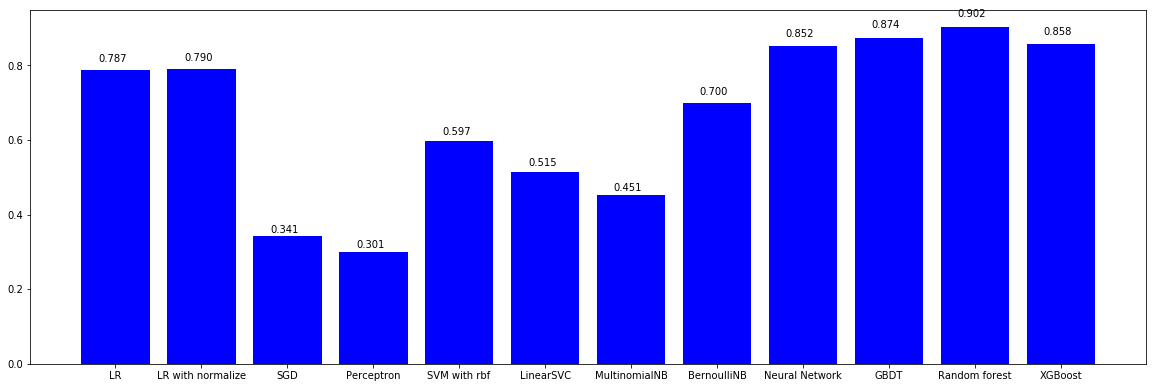

In [16]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2.- 0.2, 1.03*height, '%.3f' % float(height))
plt.figure(figsize=(20, 6.5))
autolabel(plt.bar(range(len(results)), results, color='b', tick_label=names))
plt.show()

### tunning model

In [17]:
tunned_parameters = [{'n_estimators':[5,10,50,100],'n_jobs':[-1],'max_depth':[None, 10,50,100],
                     "max_features":['auto','log2'],'min_samples_split' : [2,4,10] }]
rf_cv = GridSearchCV(RandomForestClassifier(), tunned_parameters, cv=3,n_jobs = -1)

In [18]:
%%time
rf_cv.fit(x_train,y_train)

CPU times: user 4.2 s, sys: 334 ms, total: 4.53 s
Wall time: 51.3 s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [5, 10, 50, 100], 'n_jobs': [-1], 'max_depth': [None, 10, 50, 100], 'max_features': ['auto', 'log2'], 'min_samples_split': [2, 4, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
print(rf_cv.best_score_)
print(rf_cv.best_params_)

0.9092100039698293
{'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}


In [21]:
best_rf = RandomForestClassifier(**rf_cv.best_params_)
benchmark(best_rf)

________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train time: 0.651s
test time:  0.319s
train accuracy:   0.999
test accuracy:   0.911
confusion matrix:
525     3       30      0       0       0       12      0       2       0       6       5       0       7       0       0       0       0       0       0       0       0       
2       250     1       0       0       2       0       1       2       0       0       0       0       0       2       2       1       0       0       15      0       0       
19      0       1030    0   

0.9108002964060763

### feature importance

In [22]:
def feature_importance(clf):
    with open("feature_name","r",encoding='utf-8') as f:
        feature_name = f.read().strip()
    feature_name = feature_name.split()
    feature_importance = clf.feature_importances_
    feature_name_with_import = zip(feature_name,feature_importance)
    feature_name_with_import = sorted(feature_name_with_import,key=lambda x : x[1],reverse=True) 
    for name,score in feature_name_with_import:
        print("{:<35} : {:<5f}".format(name,score))

In [23]:
feature_importance(best_rf)

LetterInMaterial                    : 0.124408
FirstLetterBeforeUnderline          : 0.098918
ChineseInProblem                    : 0.076728
LetterInAnalysis                    : 0.072222
LetterInProblem                     : 0.070201
LetterInAnswer                      : 0.067242
ChineseInAnalysis                   : 0.060642
UnderlineNumInMaterial              : 0.042083
PeopleInMaterial                    : 0.041734
ChineseInMaterial                   : 0.040883
UnderlineEmptyNumInMaterial         : 0.039573
NumOfBlankAfterUnderline            : 0.033249
SingleChoiceAns                     : 0.032523
ChangeSentenceInProblem             : 0.027748
MultiChoiceAns                      : 0.023711
HasUnderlineInProblemOrMaterial     : 0.023504
HasSoundmark                        : 0.017990
HasProperFormInMaterial             : 0.013837
HasBracketInProblem                 : 0.013678
HasLetterBeforeBlank                : 0.012149
HasBlankInProblem                   : 0.009395
HasBoldInProb